**What is GAN?**

Generative Adversarial Network or GAN is a machine learning approach used for generative modelling designed by Ian Goodfellow and his colleagues in 2014. A GAN consists of two models: a generator and a discriminator, both of which are trained simultaneously by an adversarial process. The generator learns to generate images that look like real images, while the discriminator learns to differentiate between the real and the fake images


**Implementation**

The following code demonstrates the implementation of Deep Convolutional Generative Adversarial Network (DCGAN) in Pytorch on the Human Faces dataset.

In [52]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from glob import glob

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


Inputs

dataroot - the path to the root of the dataset folder. We will talk more about the dataset in the next section

workers - the number of worker threads for loading the data with the DataLoader

batch_size - the batch size used in training. The DCGAN paper uses a batch size of 128

image_size - the spatial size of the images used for training. This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed. See here for more details

image_channels - number of color channels in the input images. For color images this is 3

vector_len - length of latent vector

ngf - relates to the depth of feature maps carried through the generator

ndf - sets the depth of feature maps propagated through the discriminator

num_epochs - number of training epochs to run. Training for longer will probably lead to better results but will also take much longer

lr - learning rate for training. As described in the DCGAN paper, this number should be 0.0002

beta1 - beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5

ngpu - number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs

In [83]:
# Root directory for dataset
dataroot = "HumanFaces"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
image_channels = 3

# Size of z latent vector (i.e. size of generator input)
vector_len = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [54]:
# images_dataset = glob("HumanFaces/*")
# image_count = len(list(images_dataset))
# print(image_count)

In [55]:
# faces = list(images_dataset)
# PIL.Image.open(str(faces[4]))

**Dataset**

The dataset used below is from the kaggle - https://www.kaggle.com/datasets/ashwingupta3012/human-faces
the dataset comprises of 7.2k approx images of human faces comprising of all age and gender
After loading the dataset, we will set the device to run and visualize some training data.

(Note - The code is using CPU when executed, and not the GPU.)

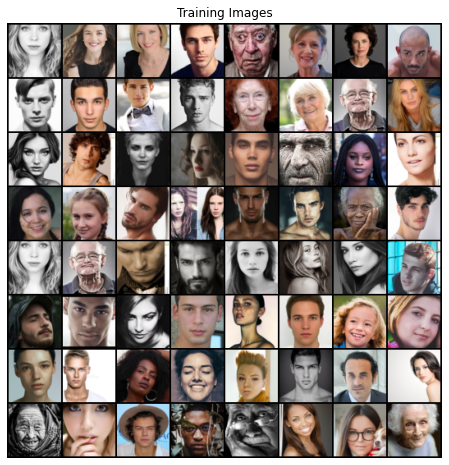

In [81]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

As our data and inputs are ready, we begin with the implementation.

We start with weight initialization. It is suggested that for all the weights or kernels in the DCGAN, weight initializer must be randomly initialized from a normal distribution with mean=0.0 and standard deviation = 0.02.


The function, weights_init takes an initialized model as input, then reinitializes all convolutional, convolutional-transpose, and batch normalization layers. Then it is applied to the models immediately after initialization.

In [57]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

**Generator**

The generator takes the random noise in the latent vector and maps it to the data space. As we are using RGB images, so our data-space means creating an RGB image.

The series of transpose convolution, batch normalization and the relu activation functio is defined, but for the last layer we use Tanh

Here, the inputs we set in the input section (vector_len, ngf, and image_channel) influence the generator architecture in code. vector_len is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and image_channel is the no. of channels in the output image (set to 3 for RGB images)

In [58]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( vector_len, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, image_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (image_channels) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

Now, we are instantiating the generator

In [59]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


**Discriminator**

The discriminator is a simple binary classification network that takes both the real and the fake image and outputs a probability of whether the given image is real or fake.


Setting the Discriminator architecture with LeakyRelu as activation function

In [60]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (image_channels) x 64 x 64
            nn.Conv2d(image_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now, we can instantiate the discriminator, apply the weights_init function to it, then print the structure.

In [61]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


The loss function used here is Binary Cross Entropy loss which is defined as     
    ℓ(x,y)=L={l 
1
​
 ,…,l 
N
​
 } 
⊤
 ,l 
n
​
 =−[y 
n
​
 ⋅logx 
n
​
 +(1−y 
n
​
 )⋅log(1−x 
n
​
 )]

In [84]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, vector_len, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

**Complete Model**

The below code is the implementation of the pseudo code of GAN model - 

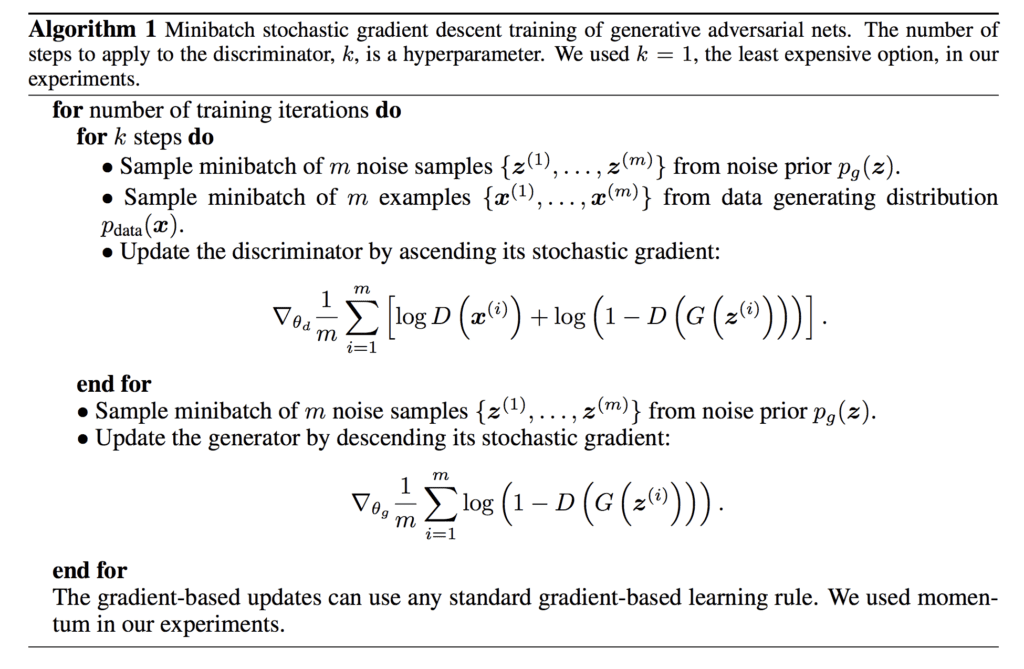


In [16]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, vector_len, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[0/5][0/57]	Loss_D: 1.6547	Loss_G: 6.1664	D(x): 0.6028	D(G(z)): 0.5840 / 0.0033


/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[0/5][50/57]	Loss_D: 0.0581	Loss_G: 5.6650	D(x): 0.9683	D(G(z)): 0.0226 / 0.0058
[1/5][0/57]	Loss_D: 0.0106	Loss_G: 27.6558	D(x): 0.9900	D(G(z)): 0.0000 / 0.0000


/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[1/5][50/57]	Loss_D: 0.6929	Loss_G: 8.9724	D(x): 0.9540	D(G(z)): 0.4262 / 0.0002


/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[2/5][0/57]	Loss_D: 0.8753	Loss_G: 10.3524	D(x): 0.9119	D(G(z)): 0.5035 / 0.0001
[2/5][50/57]	Loss_D: 0.5669	Loss_G: 5.1546	D(x): 0.9422	D(G(z)): 0.3470 / 0.0129
[3/5][0/57]	Loss_D: 0.7246	Loss_G: 6.9510	D(x): 0.9331	D(G(z)): 0.4241 / 0.0031


/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[3/5][50/57]	Loss_D: 0.4911	Loss_G: 5.2106	D(x): 0.8480	D(G(z)): 0.2423 / 0.0083


/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[4/5][0/57]	Loss_D: 1.6133	Loss_G: 12.5502	D(x): 0.9270	D(G(z)): 0.7487 / 0.0000
[4/5][50/57]	Loss_D: 1.4065	Loss_G: 5.4010	D(x): 0.9322	D(G(z)): 0.5991 / 0.0163


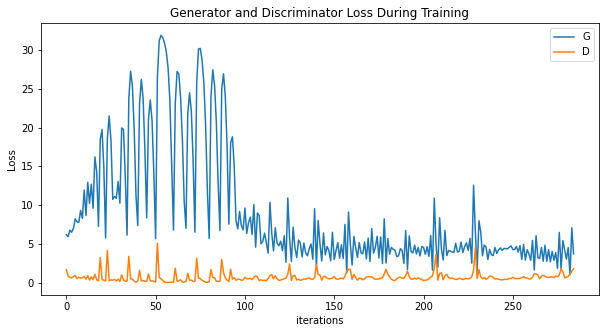

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

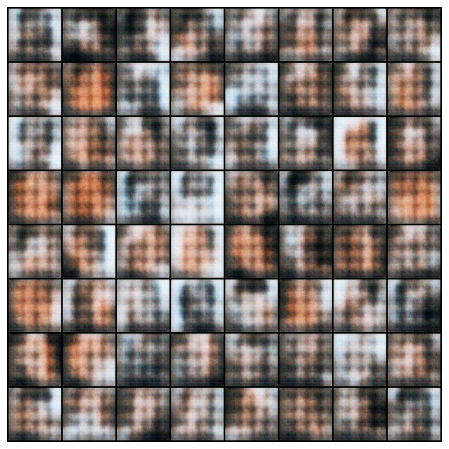

In [18]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

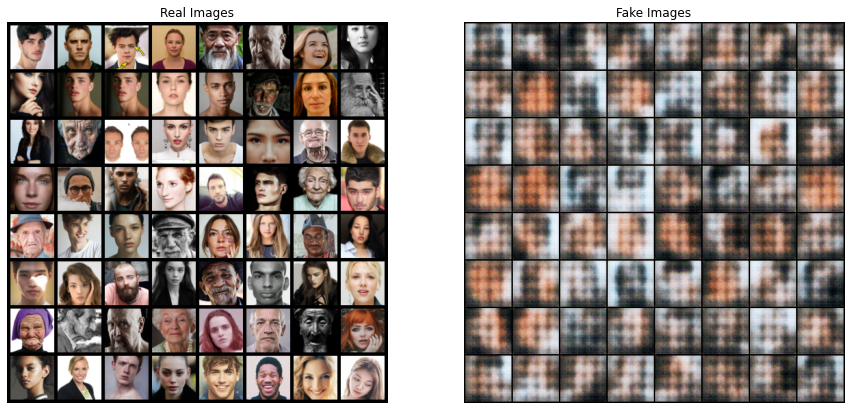

In [19]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

**Changing the latent space and architecture to see the difference in results**

latent space changed from 100 to 150,
and architecture is changed as - Generator is designed using LeakyRelu as activation function whereas Discriminator is designed using ReLu as activation function.

In [42]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
image_channels = 3

# Size of z latent vector (i.e. size of generator input)
vector_len = 150

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


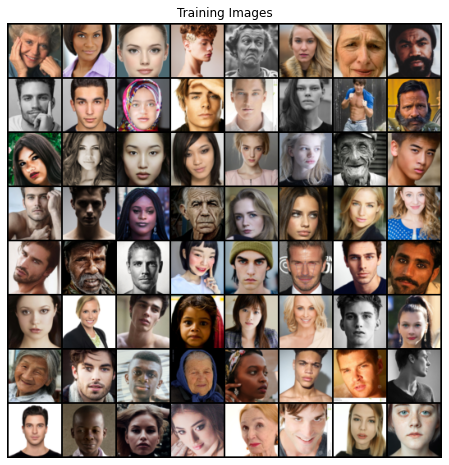

In [62]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [71]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [72]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( vector_len, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
#             nn.ReLU(True)
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
#             nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
#             nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, image_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (image_channels) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [73]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTrans

In [74]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (image_channels) x 64 x 64
            nn.Conv2d(image_channels, ndf, 4, 2, 1, bias=False),
            nn.ReLU(True),
#             nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.ReLU(True),
#             nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.ReLU(True),
#             nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.ReLU(True),
#             nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [75]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [76]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, vector_len, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [77]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, vector_len, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/57]	Loss_D: 1.5516	Loss_G: 2.8622	D(x): 0.4787	D(G(z)): 0.4576 / 0.0693


/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[0/5][50/57]	Loss_D: 0.0507	Loss_G: 10.1477	D(x): 0.9606	D(G(z)): 0.0030 / 0.0001


/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[1/5][0/57]	Loss_D: 0.4572	Loss_G: 23.5515	D(x): 0.9972	D(G(z)): 0.3464 / 0.0000


/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[1/5][50/57]	Loss_D: 0.1944	Loss_G: 8.9035	D(x): 0.8769	D(G(z)): 0.0005 / 0.0019
[2/5][0/57]	Loss_D: 3.1147	Loss_G: 12.2004	D(x): 0.9990	D(G(z)): 0.7582 / 0.0000


/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[2/5][50/57]	Loss_D: 0.3891	Loss_G: 4.5901	D(x): 0.9416	D(G(z)): 0.2505 / 0.0161
[3/5][0/57]	Loss_D: 1.3566	Loss_G: 6.4668	D(x): 0.9746	D(G(z)): 0.6610 / 0.0025


/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[3/5][50/57]	Loss_D: 0.4509	Loss_G: 3.9063	D(x): 0.7799	D(G(z)): 0.1120 / 0.0488
[4/5][0/57]	Loss_D: 0.4161	Loss_G: 4.1209	D(x): 0.7560	D(G(z)): 0.0455 / 0.0294


/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/agarwal.bh/.conda/envs/TF_env/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[4/5][50/57]	Loss_D: 0.4684	Loss_G: 4.6076	D(x): 0.8590	D(G(z)): 0.2012 / 0.0177


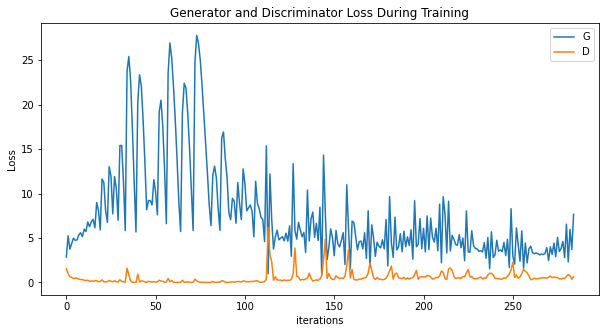

In [78]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

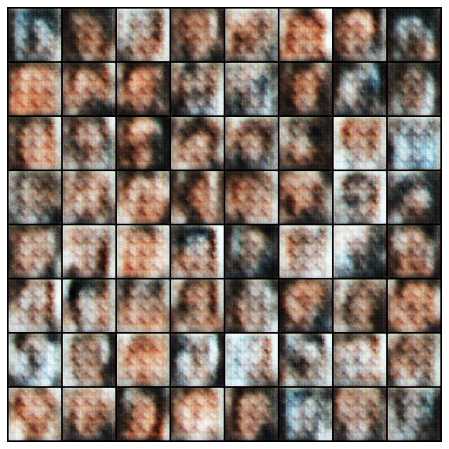

In [79]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

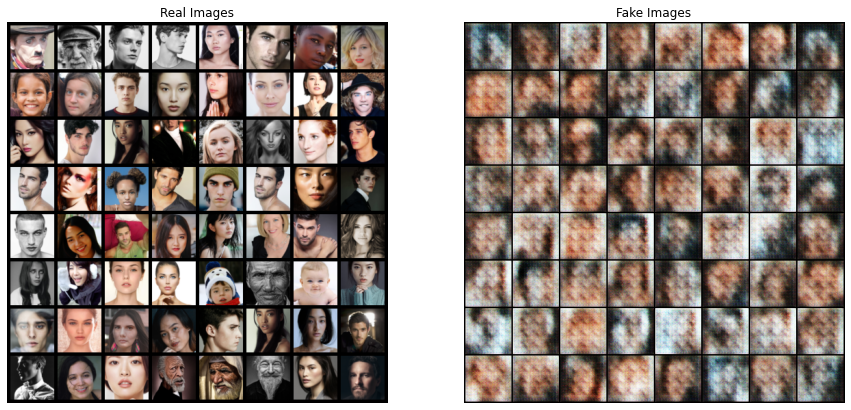

In [80]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

**Conclusion**

Had we executed the code for more number of epochs, we could have achieved better results. 
Also, changing the activation function in the architecture did reduce the loss but the reduction was not very huge.

    (Note: Because of the depth knowledge and GPU, I performed this experiment with 5 number of epochs. I have another piece of code coded using tensorflow, which shows the better results. The results for that experiment is in the folder samples. https://www.kaggle.com/bhawanaagarwal/assignment-4-humanfaces/edit)

**References**

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
https://medium.com/analytics-vidhya/dcgan-implementing-deep-convolutional-generative-adversarial-network-in-tensorflow-idiot-41b2ddf9eddb
https://machinelearningmastery.com/how-to-code-the-generative-adversarial-network-training-algorithm-and-loss-functions/


MIT License

Copyright (c) 2022 Bhawana Agarwal

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.